<a href="https://colab.research.google.com/github/hslrock/Disentangle/blob/master/Pytorch_FashionMNIST_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST implementation
This notebook is a straightforward implementation of the example code here: https://mc.ai/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset/ with minor changes to dataset loading. Please take a look at this webpage as well as it explains a bit more about each section of the code.

## Import code

In [0]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random;
import math;

In [0]:
# check PyTorch versions
print(torch.__version__)

1.4.0


## Load FashionMNIST dataset
This actually gets delivered with Pytorch, which is good!

In [0]:
# Use standard FashionMNIST dataset
train_dataset = dsets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [0]:
# Use standard FashionMNIST dataset
test_dataset = dsets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [0]:
num_epochs = 5; # how long to train
batch_size = 100; # how many images to put in at the same time [this mostly is limited by the GPU]
learning_rate = 0.001; # how much the network will walk into the gradient direction

## Set up the dataset for Pytorch
This uses the DataLoader class.

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

Let's plot some of the examples from the dataset to see what they are like [again, each image is simply 28x28 pixel grayscale]

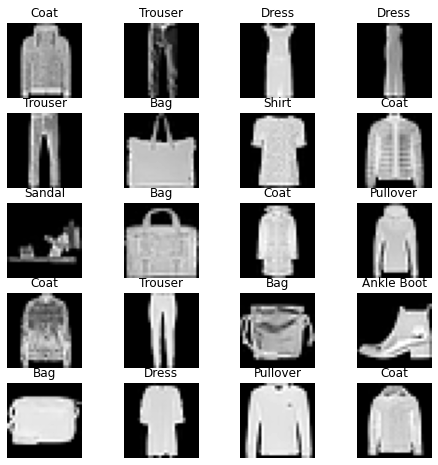

In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

## Define Convolutional Neural Network
This is not deep - in fact, it only has two layers!

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Define learning problem
Let's define the loss function [the usual cross entropy], and the optimizer [the usual ADAM, which is a bit more fancy than simple gradient descent]

In [0]:
#instance of the Conv Net
cnn = CNN();
#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);


## Train the network
For each full epoch [all images in the training dataset], let's load one batch of images, convert them so that the CNN can use it, evaluate the loss, backpropagate it, and update the weights with the gradient. Then save the current loss and keep on training.

In [0]:
losses = [];
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = Variable(images.float())
    labels = Variable(labels)
    
    # Forward + Backward + Optimize
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item());
    
    if (i+1) % 100 == 0:
        print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))

Epoch : 1/5, Iter : 100/600,  Loss: 0.2922
Epoch : 1/5, Iter : 200/600,  Loss: 0.3801
Epoch : 1/5, Iter : 300/600,  Loss: 0.2914
Epoch : 1/5, Iter : 400/600,  Loss: 0.1921
Epoch : 1/5, Iter : 500/600,  Loss: 0.2642
Epoch : 1/5, Iter : 600/600,  Loss: 0.2659
Epoch : 2/5, Iter : 100/600,  Loss: 0.3461
Epoch : 2/5, Iter : 200/600,  Loss: 0.2377
Epoch : 2/5, Iter : 300/600,  Loss: 0.5334
Epoch : 2/5, Iter : 400/600,  Loss: 0.2568
Epoch : 2/5, Iter : 500/600,  Loss: 0.3141
Epoch : 2/5, Iter : 600/600,  Loss: 0.3058
Epoch : 3/5, Iter : 100/600,  Loss: 0.3278
Epoch : 3/5, Iter : 200/600,  Loss: 0.1400
Epoch : 3/5, Iter : 300/600,  Loss: 0.4143
Epoch : 3/5, Iter : 400/600,  Loss: 0.2115
Epoch : 3/5, Iter : 500/600,  Loss: 0.2251
Epoch : 3/5, Iter : 600/600,  Loss: 0.2458
Epoch : 4/5, Iter : 100/600,  Loss: 0.2037
Epoch : 4/5, Iter : 200/600,  Loss: 0.2626
Epoch : 4/5, Iter : 300/600,  Loss: 0.2942
Epoch : 4/5, Iter : 400/600,  Loss: 0.0957
Epoch : 4/5, Iter : 500/600,  Loss: 0.2911
Epoch : 4/5

## Plot the learning progress

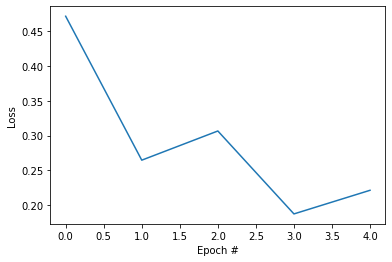

In [0]:
losses_in_epochs = losses[0::600]
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();

## Evaluate the network
Now we have a [hopefully] low loss on training, we want to test the neural network on the TEST set, so we loop through batches of test images, evaluate the labels and accumulate the accuracy values.

In [0]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.0000 %


# Visualizing the filters
What has our neural network learned? Well, each of the layers has a number of small convolutional filters that were learned from the data in order to classify the 10 Fashion classes. These filters, when convolved with an image patch of the same size will help the network to solve the task.

We can visualize these as little patches as well.

In [0]:
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [0]:
filters = cnn.modules();
model_layers = [i for i in cnn.children()];
first_layer = model_layers[0];
second_layer = model_layers[1];

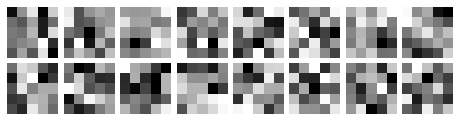

In [0]:
first_kernels = first_layer[0].weight.data.numpy()
plot_kernels(first_kernels, 8)

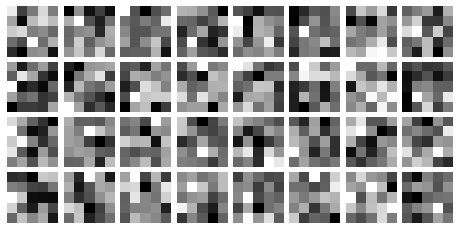

In [0]:
second_kernels = second_layer[0].weight.data.numpy()
plot_kernels(second_kernels, 8)

If you squint a little, you can perhaps begin to see some structure, but this is hard - from this little data, most networks are not able to gain "deep insight". For larger datasets and deeper networks, the first layers usually conform to simple filters [much like those found in the visual system].